<a href="https://colab.research.google.com/github/NerminWEST/Kaggle_Dataset_Fish_Model1.0/blob/main/MobileNetV2vsYOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Fish Species Detection & Recognition using Deep Learning

---

**Project Name: Fish Species Detection & Recognition using Deep Learning**

---

<center> <img src = "https://giffiles.alphacoders.com/202/20291.gif" width = 50%>

## Workflow of this notebook<a name ="h8"></a>
**1)** [Introducing the Problem](#h1)      
**2)** [Understanding the Dataset](#h2)    
**3)** [Importing necessary libraries and modules for this notebook](#h3)      
**4)** [Exploratory Analysis](#h4)           
**5)** [Image Generation & Preprocessing](#h5)   
**6)** [Model Training & Evaluation](#h6)        


## Introduction to the Problem<a name ="h1"></a>

<p align="justify">Estimating the relative abundance of fish species in their habitats on a regular basis and keeping an eye on population fluctuations are crucial tasks for marine scientists and conservationists. Diverse automatic computer-based fish sample methods have been demonstrated in underwater photos and videos as alternatives to time-consuming hand sampling. There isn't, however, a perfect method for automatically detecting fish and classifying their species. This is mostly due to the difficulties in producing clear underwater images and videos, which include environmental fluctuations in lighting, fish camouflage, dynamic backdrops, murky water, low resolution, shape deformations of moving fish, and tiny variances between some fish species.

## Understanding the Dataset<a name ="h2"></a>

[This dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset) contains 9 different seafood types - These include gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples. For each class, there are 1000 augmented images and their pair-wise augmented ground truths. Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".


<p align="justify">For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT".

For the purpose of this analysis, we shall be using only the augmented images.
--


*Credits to this dataset -*

O.Ulucan, D.Karakaya, and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)


## Importing necessary libraries and modules for this notebook<a name ="h3"></a>

In [1]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2

'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")

## Exploratory Analysis<a name ="h4"></a>

In [2]:
import os
import kagglehub

# Download dataset
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")
print("Dataset downloaded to:", path)

# Correct DIR path
DIR = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

# Validate
if not os.path.exists(DIR):
    raise Exception(f"❌ DIR does not exist: {DIR}")

# Extract classes
classes = [d for d in os.listdir(DIR) if os.path.isdir(os.path.join(DIR, d))]

print("✔ Classes detected:")
print(classes)


100%|██████████| 3.24G/3.24G [00:29<00:00, 120MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2
✔ Classes detected:
['Red Mullet', 'Hourse Mackerel', 'Trout', 'Gilt-Head Bream', 'Black Sea Sprat', 'Striped Red Mullet', 'Sea Bass', 'Red Sea Bream', 'Shrimp']


In [3]:
# --- IMPORTS ---
import os
import pandas as pd

# --- SET THE CORRECT DATASET DIRECTORY ---
DIR = "/root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset"

# --- VALIDATE DIRECTORY ---
if not os.path.exists(DIR):
    raise Exception(f"❌ The directory does NOT exist:\n{DIR}\nCheck your dataset structure.")

# --- SHOW FOLDERS INSIDE DATASET (CLASSES) ---
print("Contents of DIR:")
print(os.listdir(DIR))

# --- EXTRACT CLASS FOLDERS ---
classes = [folder for folder in os.listdir(DIR) if os.path.isdir(os.path.join(DIR, folder))]

print("\n✔ Classes detected:")
for c in classes:
    print(" -", c)

# --- READY FOR NEXT STEP (creating dataframe) ---
print("\nDIR is ready. You can now run the dataframe creation cell.")


Contents of DIR:
['Segmentation_example_script.m', 'Red Mullet', 'README.txt', 'Hourse Mackerel', 'license.txt', 'Trout', 'Gilt-Head Bream', 'Black Sea Sprat', 'Striped Red Mullet', 'Sea Bass', 'Red Sea Bream', 'Shrimp']

✔ Classes detected:
 - Red Mullet
 - Hourse Mackerel
 - Trout
 - Gilt-Head Bream
 - Black Sea Sprat
 - Striped Red Mullet
 - Sea Bass
 - Red Sea Bream
 - Shrimp

DIR is ready. You can now run the dataframe creation cell.


In [4]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [6]:
df.head()

,path,label
0,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Sea Bream
1,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Sea Bream
2,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Sea Bream
3,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Sea Bream
4,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Sea Bream


In [5]:
df.path[0]

'/root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00805.png'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [7]:
#Checking the value counts of each of the datasets
#df['label']=df['label'].astype('category')
df['label'].value_counts()

,count
label,
Red Mullet,1000
Hourse Mackerel,1000
Trout,1000
Gilt-Head Bream,1000
Black Sea Sprat,1000
Striped Red Mullet,1000
Sea Bass,1000
Red Sea Bream,1000
Shrimp,1000


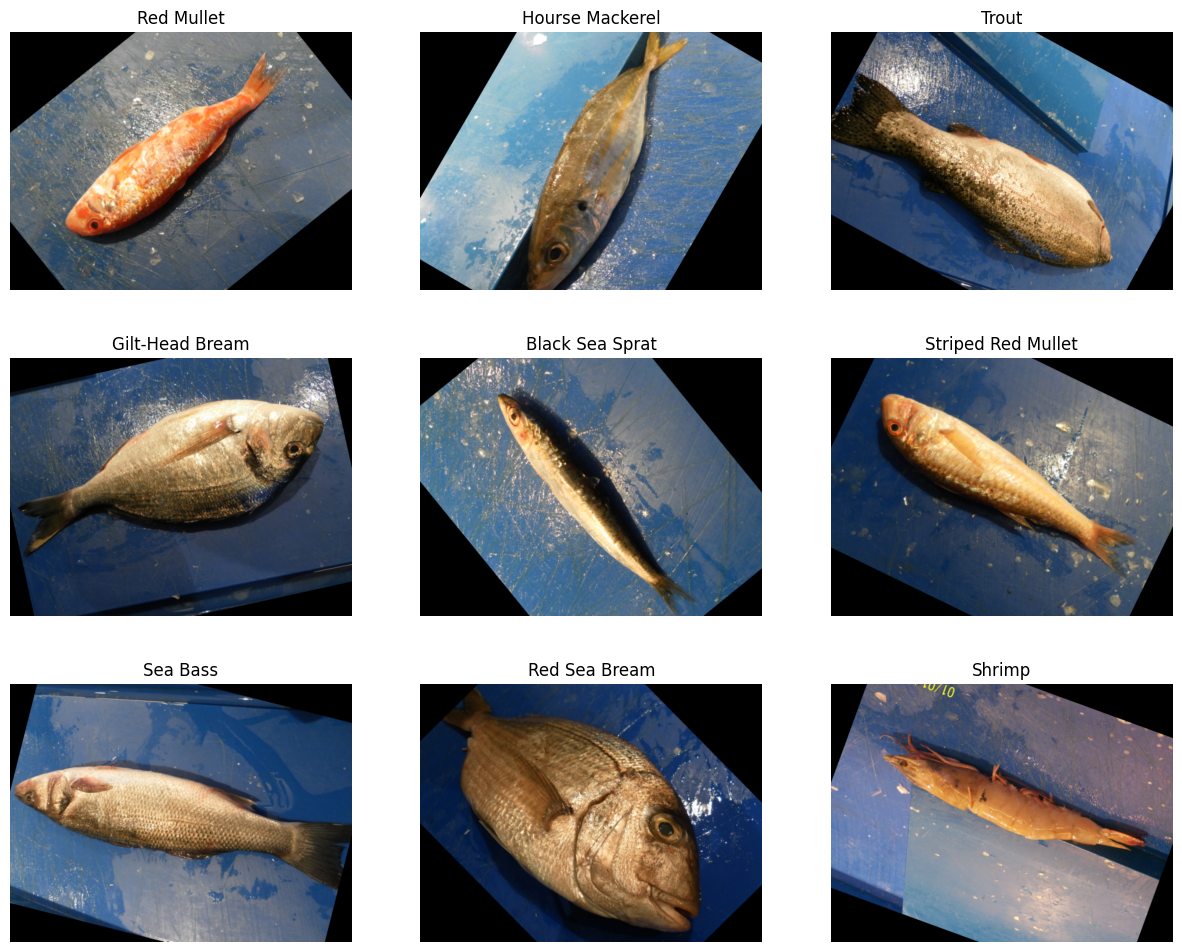

In [8]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

## Test-Train Split

In [9]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [10]:
#Checking the shaoe of the newly obtained data
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


## Image Generation and Preprocessing<a name ="h5"></a>

In [11]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [13]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

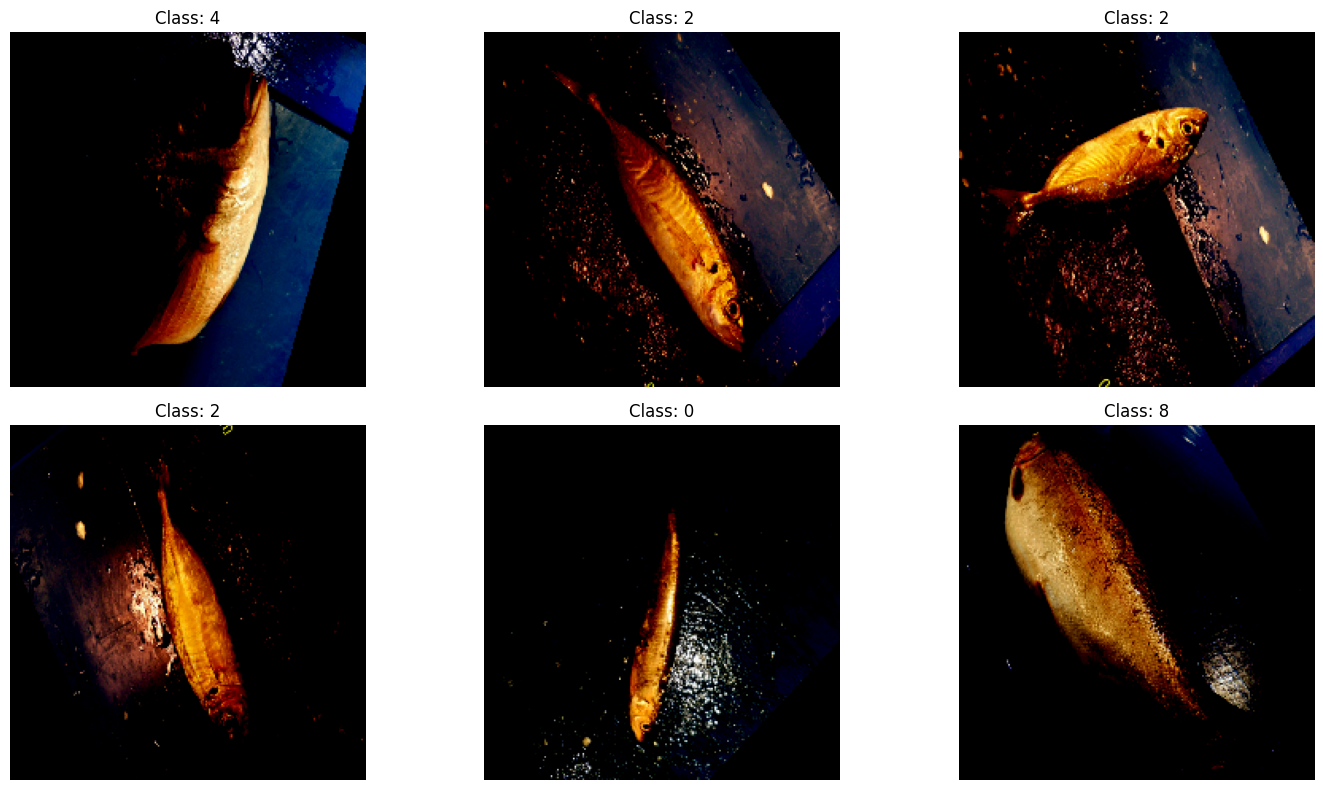

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax = ax.flatten()

for j in range(6):
    img, label = next(test_images)     # CORRECT way to get batch
    ax[j].imshow(img[0])

    # Convert one-hot → class index
    if hasattr(label, "__len__") and len(label[0]) > 1:
        class_id = label[0].argmax()
    else:
        class_id = label[0]

    ax[j].set_title(f"Class: {class_id}")
    ax[j].axis("off")

plt.tight_layout()
plt.show()


## Model Training and Evaluation<a name ="h6"></a>

## MobileNet v2 Architecture -
<center> <img src = "https://1.bp.blogspot.com/-M8UvZJWNW4E/WsKk-tbzp8I/AAAAAAAAChw/OqxBVPbDygMIQWGug4ZnHNDvuyK5FBMcQCLcBGAs/s1600/image5.png" width = 60%></center>

<p align="justify">MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.


In [15]:
#Importing our pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
#Creating our model inputs
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,625 (9.31 MB)

 Trainable params: 181,641 (709.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8540 - loss: 0.5031 - val_accuracy: 0.9951 - val_loss: 0.0239
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9954 - loss: 0.0190 - val_accuracy: 0.9854 - val_loss: 0.0404
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9965 - val_loss: 0.0123
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9986 - val_loss: 0.0051
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 1.0000 - loss: 4.6342e-04 - val_accuracy: 0.9986 - val_loss: 0.0041


In [17]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00223
Test Accuracy: 99.94%


In [18]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step


In [19]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [20]:
# Visualize the pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Sea Bream,Red Sea Bream
1,/root/.cache/kagglehub/datasets/crowww/a-large...,Hourse Mackerel,Hourse Mackerel
2,/root/.cache/kagglehub/datasets/crowww/a-large...,Red Mullet,Red Mullet
3,/root/.cache/kagglehub/datasets/crowww/a-large...,Black Sea Sprat,Black Sea Sprat
4,/root/.cache/kagglehub/datasets/crowww/a-large...,Shrimp,Shrimp
5,/root/.cache/kagglehub/datasets/crowww/a-large...,Shrimp,Shrimp
6,/root/.cache/kagglehub/datasets/crowww/a-large...,Striped Red Mullet,Striped Red Mullet
7,/root/.cache/kagglehub/datasets/crowww/a-large...,Shrimp,Shrimp
8,/root/.cache/kagglehub/datasets/crowww/a-large...,Gilt-Head Bream,Gilt-Head Bream
9,/root/.cache/kagglehub/datasets/crowww/a-large...,Black Sea Sprat,Black Sea Sprat


In [21]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

,path,label,pred
1123,/root/.cache/kagglehub/datasets/crowww/a-large...,Black Sea Sprat,Hourse Mackerel


In [22]:
pred_df.path[1604]

'/root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet/00386.png'

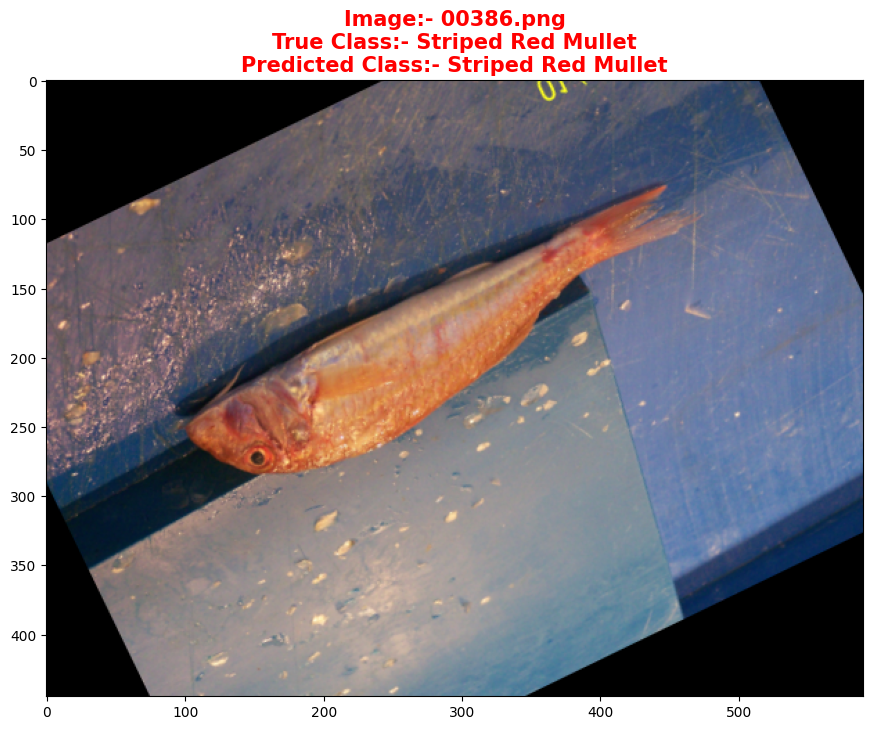

In [23]:
# Which image was it?
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1604]))
title1 = pred_df.path[1604].split('/')[-2]
title2 = pred_df.path[1604].split('/')[-1]
title3 = pred_df.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.9994444444444445


<Axes: >

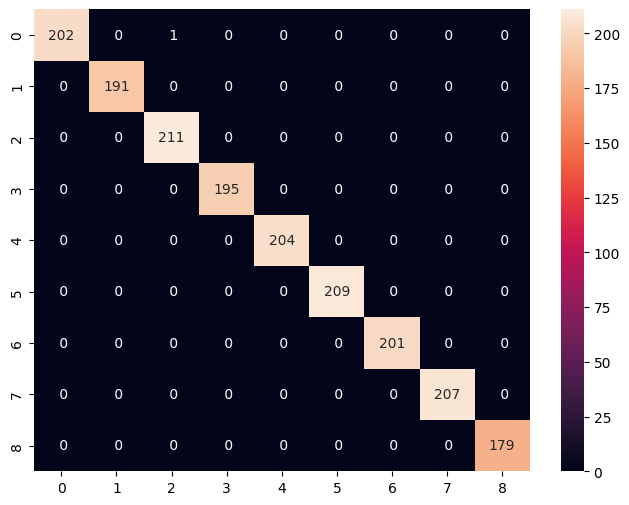

In [25]:
#Checking the accuracy score and creating a Confusion Matrix
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [26]:
#Generating the Classification Report for in-depth analysis
print(classification_report(pred_df['label'],pred_df['pred']))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       203
   Gilt-Head Bream       1.00      1.00      1.00       191
   Hourse Mackerel       1.00      1.00      1.00       211
        Red Mullet       1.00      1.00      1.00       195
     Red Sea Bream       1.00      1.00      1.00       204
          Sea Bass       1.00      1.00      1.00       209
            Shrimp       1.00      1.00      1.00       201
Striped Red Mullet       1.00      1.00      1.00       207
             Trout       1.00      1.00      1.00       179

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



In [44]:
# ===========================
#   YOLOv8 FULL PIPELINE
# ===========================
!pip install ultralytics

import os
import glob
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import kagglehub

# ---------------------------
# DOWNLOAD DATASET
# ---------------------------
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")
print("Downloaded:", path)

# Correct dataset path
DIR = "/root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/NA_Fish_Dataset"
print("Using dataset path:", DIR)

# ---------------------------
# GET CLASS FOLDERS
# ---------------------------
classes = sorted([d for d in os.listdir(DIR) if os.path.isdir(os.path.join(DIR, d))])
print("Classes:", classes)

class_map = {cls: i for i, cls in enumerate(classes)}
print("Class mapping:", class_map)

# ---------------------------
# COLLECT ALL IMAGES
# ---------------------------
all_images = []
for cls in classes:
    img_path = os.path.join(DIR, cls)
    images = glob.glob(os.path.join(img_path, "*.png")) + \
             glob.glob(os.path.join(img_path, "*.jpg")) + \
             glob.glob(os.path.join(img_path, "*.jpeg"))

    for img in images:
        all_images.append((img, class_map[cls]))

print("Total images found:", len(all_images))

if len(all_images) == 0:
    raise Exception("ERROR: No images found! Wrong dataset path.")

# ---------------------------
# TRAIN/VAL SPLIT
# ---------------------------
train_set, val_set = train_test_split(all_images, test_size=0.2, random_state=42)

# ---------------------------
# CREATE YOLO FOLDERS
# ---------------------------
base = "/content/yolo_fish"
for f in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(base, f), exist_ok=True)

# ---------------------------
# COPY + CREATE LABELS
# ---------------------------
def create_label_file(img_path, cls_id):
    label_path = img_path.replace("images", "labels").replace(".png", ".txt").replace(".jpg",".txt")
    with open(label_path, "w") as f:
        f.write(f"{cls_id} 0.5 0.5 1.0 1.0")

def process_dataset(dataset, split):
    for img, cls_id in tqdm(dataset):
        filename = os.path.basename(img)
        dest_path = f"{base}/images/{split}/{filename}"
        shutil.copy(img, dest_path)
        create_label_file(dest_path, cls_id)

process_dataset(train_set, "train")
process_dataset(val_set, "val")

# ---------------------------
# CREATE fish.yaml
# ---------------------------
yaml = f"""
path: {base}
train: images/train
val: images/val
names: {classes}
"""

with open("fish.yaml", "w") as f:
    f.write(yaml)

print("YOLO Dataset Created Successfully!")



Using Colab cache for faster access to the 'a-large-scale-fish-dataset' dataset.
Downloaded: /kaggle/input/a-large-scale-fish-dataset
Using dataset path: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/NA_Fish_Dataset
Classes: ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
Class mapping: {'Black Sea Sprat': 0, 'Gilt Head Bream': 1, 'Horse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}
Total images found: 282


100%|██████████| 57/57 [00:00<00:00, 95.31it/s] 

YOLO Dataset Created Successfully!


In [40]:
import os

print("Searching for 'Fish_Dataset'...")

for root, dirs, files in os.walk("/root", topdown=True):
    for d in dirs:
        if "Fish_Dataset" in d:
            print("FOUND:", os.path.join(root, d))


Searching for 'Fish_Dataset'...
FOUND: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/NA_Fish_Dataset
FOUND: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset
FOUND: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset


#### We have achieved an accuracy of 100%, which clearly demonstrates the power of transfer learning.



---

### References to learn more -
1. [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning - Towards Data Science](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
2. [Introduction to Transfer Learning - Geeks for Geeks](https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/)
3. [Another example to classify images of cats and dogs by using transfer learning from a pre-trained network - Tensorflow](https://www.tensorflow.org/tutorials/images/transfer_learning)


In [45]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="fish.yaml", epochs=30, imgsz=416)


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fish.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2, 3, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c4e4bd308c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [52]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ----------------------
# 1) Correct dataset path
# ----------------------
DATASET = "/root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/NA_Fish_Dataset"

print("Using dataset:", DATASET)

# ----------------------
# 2) Get class names
# ----------------------
classes = sorted([d for d in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, d))])
print("Classes:", classes)

# Map: class_name → numeric id
class_to_id = {cls: i for i, cls in enumerate(classes)}
print("Class mapping:", class_to_id)

# ----------------------
# 3) Gather all images
# ----------------------
all_images = []
for cls in classes:
    folder = os.path.join(DATASET, cls)
    for f in os.listdir(folder):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            all_images.append((os.path.join(folder, f), cls))

print("Total images found:", len(all_images))

# ----------------------
# 4) Train/Val split
# ----------------------
train_set, val_set = train_test_split(all_images, test_size=0.2, random_state=42, shuffle=True)

# ----------------------
# 5) Create YOLO folders
# ----------------------
if os.path.exists("fish_yolo"):
    shutil.rmtree("fish_yolo")

os.makedirs("fish_yolo/images/train", exist_ok=True)
os.makedirs("fish_yolo/images/val", exist_ok=True)
os.makedirs("fish_yolo/labels/train", exist_ok=True)
os.makedirs("fish_yolo/labels/val", exist_ok=True)

# ----------------------
# 6) Convert to YOLO format (classification = no boxes → class_id only)
# ----------------------
def save_yolo_label(label_path, class_id):
    with open(label_path, "w") as f:
        f.write(f"{class_id}")

def copy_and_label(dataset, split):
    for img, cls in tqdm(dataset, desc=f"Converting {split}"):
        filename = os.path.basename(img)
        shutil.copy(img, f"fish_yolo/images/{split}/{filename}")

        label_id = class_to_id[cls]
        label_path = f"fish_yolo/labels/{split}/{filename.rsplit('.',1)[0]}.txt"
        save_yolo_label(label_path, label_id)

copy_and_label(train_set, "train")
copy_and_label(val_set, "val")

# ----------------------
# 7) Create data.yaml
# ----------------------
yaml_content = f"""
path: {os.getcwd()}/fish_yolo
train: images/train
val: images/val

names:
"""

for cls in classes:
    yaml_content += f"  {class_to_id[cls]}: {cls}\n"

with open("fish.yaml", "w") as f:
    f.write(yaml_content)

print("\n🎉 YOLOv8 dataset created successfully!")
print("✔ Folder: fish_yolo/")
print("✔ Config file: fish.yaml")


Using dataset: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/NA_Fish_Dataset
Classes: ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
Class mapping: {'Black Sea Sprat': 0, 'Gilt Head Bream': 1, 'Horse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}
Total images found: 430


Converting val: 100%|██████████| 86/86 [00:01<00:00, 59.73it/s]


🎉 YOLOv8 dataset created successfully!
✔ Folder: fish_yolo/
✔ Config file: fish.yaml


In [55]:
import os
import shutil

# Make classification folders
if os.path.exists("fish_cls"):
    shutil.rmtree("fish_cls")

os.makedirs("fish_cls/train", exist_ok=True)
os.makedirs("fish_cls/val", exist_ok=True)

# Move only the images, ignore labels
for split in ["train", "val"]:
    src = f"fish_yolo/images/{split}"
    dst = f"fish_cls/{split}"

    for f in os.listdir(src):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("✔ Classification dataset ready at: fish_cls/")


✔ Classification dataset ready at: fish_cls/


In [57]:
import os
import shutil
from sklearn.model_selection import train_test_split

# ORIGINAL DATASET (with class folders)
SOURCE = "/root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/NA_Fish_Dataset"

# NEW YOLOv8 CLASSIFICATION DATASET
DATASET = "fish_cls"

# Delete old dataset if exists
if os.path.exists(DATASET):
    shutil.rmtree(DATASET)

# Create structure
os.makedirs(f"{DATASET}/train", exist_ok=True)
os.makedirs(f"{DATASET}/val", exist_ok=True)

# Detect class names
classes = [d for d in os.listdir(SOURCE) if os.path.isdir(os.path.join(SOURCE, d))]
print("Detected classes:", classes)

# Process each class
for cls in classes:
    src = os.path.join(SOURCE, cls)
    imgs = [f for f in os.listdir(src) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # train/val split (80/20)
    train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    # create class folders
    os.makedirs(f"{DATASET}/train/{cls}", exist_ok=True)
    os.makedirs(f"{DATASET}/val/{cls}", exist_ok=True)

    # copy train images
    for img in train_imgs:
        shutil.copy(os.path.join(src, img), f"{DATASET}/train/{cls}/{img}")

    # copy val images
    for img in val_imgs:
        shutil.copy(os.path.join(src, img), f"{DATASET}/val/{cls}/{img}")

print("\n✔ Dataset ready in:", DATASET)


Detected classes: ['Red Mullet', 'Horse Mackerel', 'Trout', 'Black Sea Sprat', 'Striped Red Mullet', 'Gilt Head Bream', 'Sea Bass', 'Red Sea Bream', 'Shrimp']

✔ Dataset ready in: fish_cls


In [58]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")
model.train(
    data="fish_cls",
    epochs=20,
    imgsz=224
)


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fish_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c4e42667710>
curves: []
curves_results: []
fitness: 0.9941860437393188
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9883720874786377, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9941860437393188}
save_dir: PosixPath('/content/runs/classify/train4')
speed: {'preprocess': 0.0018353488443143189, 'inference': 9.997576674417951, 'loss': 6.138373274277614e-05, 'postprocess': 0.00013219766705608278}
task: 'classify'
top1: 0.9883720874786377
top5: 1.0

Searching for the dataset

In [62]:
import os

print("Searching for Fish_Dataset ...\n")

matches = []
for root, dirs, files in os.walk("/content", topdown=True):
    for d in dirs:
        if "fish" in d.lower():  # finds Fish_Dataset, fish_dataset, fish, etc.
            matches.append(os.path.join(root, d))

print("Found:")
print("\n".join(matches) if matches else " No dataset found")


Searching for Fish_Dataset ...

Found:
/content/fish_cls
/content/yolo_fish
/content/yolo_fish_det
/content/fish_yolo


**MOBILNET TRAINING**

In [64]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import os

IMG_SIZE = 224
BATCH = 32

# ---------------------------
# FIXED DATASET PATH
# ---------------------------
dataset_path = "/content/fish_cls"

train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "val")
test_dir  = os.path.join(dataset_path, "test")

print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)

# ---------------------------
# LOAD DATA
# ---------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical"
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical"
)

# ---------------------------
# BUILD MODEL
# ---------------------------
base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ---------------------------
# TRAIN
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

model.save("mobilenet_fish.h5")
print("Model saved → mobilenet_fish.h5")


Train: /content/fish_cls/train
Val: /content/fish_cls/val
Test: /content/fish_cls/test
Found 344 images belonging to 9 classes.
Found 86 images belonging to 9 classes.
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.3547 - loss: 1.8439 - val_accuracy: 0.8721 - val_loss: 0.5826
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8807 - loss: 0.4233 - val_accuracy: 0.9651 - val_loss: 0.2067
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9648 - loss: 0.1686 - val_accuracy: 0.9767 - val_loss: 0.1554
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9763 - loss: 0.0925 - val_accuracy: 0.9767 - val_loss: 0.0877
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9815 - loss: 0.0550 - val_accuracy: 0.9767 - val_loss: 0.0731
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9918 - loss: 0.0368 - val_accuracy: 0.9884 - val_loss: 0.0524
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss:

Model saved → mobilenet_fish.h5


In [68]:
from ultralytics import YOLO

# Train YOLOv8 classification model
model = YOLO("yolov8n-cls.pt")

model.train(
    data="/content/fish_cls",   # full path from debug
    epochs=20,
    imgsz=224,
    batch=16
)


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/fish_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c4e424d1250>
curves: []
curves_results: []
fitness: 0.9941860437393188
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9883720874786377, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9941860437393188}
save_dir: PosixPath('/content/runs/classify/train5')
speed: {'preprocess': 0.0023493023226640003, 'inference': 10.274507639530574, 'loss': 7.198837751232976e-05, 'postprocess': 0.00012731395547107663}
task: 'classify'
top1: 0.9883720874786377
top5: 1.0

Using model: /content/runs/classify/train5/weights/best.pt
📤 Upload an image to classify:


Saving images (1).jfif to images (1).jfif
Using image: /content/images (1).jfif

0: 224x224 Red Mullet 0.51, Red Sea Bream 0.29, Striped Red Mullet 0.08, Horse Mackerel 0.04, Shrimp 0.03, 25.3ms
Speed: 7.9ms preprocess, 25.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


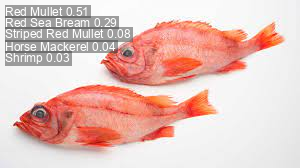


Predicted class: Red Mullet

Class probabilities:
Black Sea Sprat: 0.0018
Gilt Head Bream: 0.0220
Horse Mackerel: 0.0444
Red Mullet: 0.5130
Red Sea Bream: 0.2913
Sea Bass: 0.0108
Shrimp: 0.0272
Striped Red Mullet: 0.0750
Trout: 0.0145


In [72]:
from ultralytics import YOLO
from PIL import Image
from google.colab import files
import glob, os

# -------------------------
# 1. LOAD MODEL
# -------------------------
run_dirs = sorted(glob.glob("/content/runs/classify/train*"), reverse=True)
if not run_dirs:
    raise FileNotFoundError("No training folders found.")

best_weight = f"{run_dirs[0]}/weights/best.pt"
print("Using model:", best_weight)

model = YOLO(best_weight)

# -------------------------
# 2. UPLOAD IMAGE
# -------------------------
print("📤 Upload an image to classify:")
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
img_path = f"/content/{img_path}"

print("Using image:", img_path)

# -------------------------
# 3. RUN PREDICTION
# -------------------------
img = Image.open(img_path)
results = model(img)

results[0].show()

print("\nPredicted class:", results[0].names[results[0].probs.top1])
print("\nClass probabilities:")
for cls_id, prob in enumerate(results[0].probs.data):
    print(f"{results[0].names[cls_id]}: {float(prob):.4f}")


**YOLO VS MOBILENET**

In [73]:
import time, os, glob
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow as tf

# ------------------------------------------
# 1) Load YOLOv8
# ------------------------------------------
yolo_dir = sorted(glob.glob("/content/runs/classify/train*"), reverse=True)[0]
yolo_path = f"{yolo_dir}/weights/best.pt"
yolo_model = YOLO(yolo_path)

# ------------------------------------------
# 2) Load MobileNet model
# ------------------------------------------
mobilenet_path = "/content/mobilenet_fish.h5"
mobilenet_model = load_model(mobilenet_path)

# ------------------------------------------
# 3) Pick sample images from validation set
# ------------------------------------------
val_dir = "/content/fish_cls/val"
classes = sorted(os.listdir(val_dir))
sample_images = []

for cls in classes:
    imgs = glob.glob(f"{val_dir}/{cls}/*")
    if imgs:
        sample_images.append(imgs[0])   # take 1 image per class

print(f"Using {len(sample_images)} images for comparison")

# Preprocessing for MobileNet
IMG_SIZE = 224

def preprocess_mobilenet(img_path):
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img) / 255.0
    return np.expand_dims(arr, axis=0)

# ------------------------------------------
# 4) Run comparison
# ------------------------------------------
yolo_times = []
mobilenet_times = []
yolo_correct = 0
mobilenet_correct = 0

for img_path in sample_images:
    true_class = img_path.split("/")[-2]

    # --- YOLO ---
    start = time.time()
    yolo_pred = yolo_model(img_path)[0]
    yolo_time = time.time() - start

    yolo_pred_class = yolo_pred.names[yolo_pred.probs.top1]
    yolo_times.append(yolo_time)
    if yolo_pred_class == true_class:
        yolo_correct += 1

    # --- MobileNet ---
    img_arr = preprocess_mobilenet(img_path)

    start = time.time()
    preds = mobilenet_model.predict(img_arr, verbose=0)[0]
    mobilenet_time = time.time() - start

    mobilenet_pred_class = classes[np.argmax(preds)]
    mobilenet_times.append(mobilenet_time)
    if mobilenet_pred_class == true_class:
        mobilenet_correct += 1

# ------------------------------------------
# 5) Summary
# ------------------------------------------
print("\n==================== RESULTS ====================")

print(f"\n📌 YOLOv8")
print(f"Accuracy: {yolo_correct}/{len(sample_images)}")
print(f"Avg Inference Time: {np.mean(yolo_times)*1000:.2f} ms")
print(f"Model Size: {os.path.getsize(yolo_path)/1024/1024:.2f} MB")

print(f"\n📌 MobileNet")
print(f"Accuracy: {mobilenet_correct}/{len(sample_images)}")
print(f"Avg Inference Time: {np.mean(mobilenet_times)*1000:.2f} ms")
print(f"Model Size: {os.path.getsize(mobilenet_path)/1024/1024:.2f} MB")

print("\n=================================================")

# ------------------------------------------
# 6) Raspberry Pi Recommendation
# ------------------------------------------
print("\n📌 Recommended for Raspberry Pi:")
if np.mean(mobilenet_times) < np.mean(yolo_times):
    print("➡️ MobileNet (faster, smaller)")
else:
    print("➡️ YOLOv8 (more accurate)")


Using 9 images for comparison

image 1/1 /content/fish_cls/val/Black Sea Sprat/00041.png: 224x224 Black Sea Sprat 1.00, Striped Red Mullet 0.00, Sea Bass 0.00, Red Mullet 0.00, Trout 0.00, 26.4ms
Speed: 10.4ms preprocess, 26.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/fish_cls/val/Gilt Head Bream/19.JPG: 224x224 Gilt Head Bream 1.00, Trout 0.00, Horse Mackerel 0.00, Red Sea Bream 0.00, Sea Bass 0.00, 33.7ms
Speed: 70.8ms preprocess, 33.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/fish_cls/val/Horse Mackerel/00041.png: 224x224 Horse Mackerel 1.00, Black Sea Sprat 0.00, Red Mullet 0.00, Gilt Head Bream 0.00, Striped Red Mullet 0.00, 18.8ms
Speed: 13.9ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/fish_cls/val/Red Mullet/00041.png: 224x224 Red Mullet 1.00, Striped Red Mullet 0.00, Shrimp 0.00, Red Sea Bream 0.00, Black Sea Sprat 0.00, 14.8ms
